Paper Explained- Vision Transformers (Bye Bye Convolutions?): https://medium.com/analytics-vidhya/vision-transformers-bye-bye-convolutions-e929d022e4ab

AN IMAGE IS WORTH 16X16 WORDS: https://arxiv.org/pdf/2010.11929.pdf

Buen articulo que explica el input: https://medium.datadriveninvestor.com/coding-the-vision-transformer-in-pytorch-part-1-birds-eye-view-1c0a79d8732e

Codigo con explicacion #1: https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py

Attention Is All You Need: https://arxiv.org/pdf/1706.03762.pdf

Codigo con explicacion #2: https://theaisummer.com/vision-transformer/

In [1]:
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import math
import torchvision.datasets as datasets
from torchvision import transforms
import random
from torch.utils.data import DataLoader, Dataset

C:\Users\Erno\anaconda3\envs\torchenv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


# Hyperparameters

In [3]:
HEIGHT = 32
WIDTH = 32
CHANNELS = 1
BATCH_SIZE = 32
PATCHES_DIM = 16
EMBEDDING_DIM = 512
NUM_CLASSES = 10
NHEADS = 8
DROPOUT_P = 0.1
EPOCHS = 25
LEARNING_RATE = 1e-3
FORWARD_EXPANSION = 4
MLP_EXPANSION = 3
MOMENTUM = 0.9
NUM_LAYERS = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
DEVICE
torch.cuda.empty_cache()

# Create image tensor

In [5]:
sample_image = torch.randn(BATCH_SIZE, WIDTH, HEIGHT, CHANNELS)

# Create the input layer

### Create the patched images and add the class embedding

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_shape, patch_dim, emb_dim, device='cpu', dropout_p=0.1):
        super(PatchEmbedding, self).__init__()
        
        self.b, self.w, self.h, self.c = image_shape
        
        assert (self.w * self.h) % (patch_dim ** 2) == 0, 'Patch dimension is not valid'
        
        self.device = device
        self.dropout = nn.Dropout(dropout_p)
        self.patch_dim = patch_dim
        self.num_patches = (self.w * self.h) // (patch_dim ** 2)
        
        self.fc = nn.Sequential(
            nn.Linear(self.c * self.patch_dim * self.patch_dim, emb_dim)
        ).to(device)
        
    def forward(self, x):
        x = x.to(self.device)
        x = x.reshape(self.b, self.num_patches, self.c * self.patch_dim * self.patch_dim) # Shape - (batch, num_patches, channels * patch_dim * patch_dim)
        x = self.dropout(self.fc(x))
        
        return x, self.num_patches

### Create Positional Encoding

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, num_patches, device='cpu', dropout_p=0.1):
        super(PositionalEncoding, self).__init__()
        
        self.positions = torch.arange(0, emb_dim).expand(num_patches + 1, emb_dim).float()
        self.dropout = nn.Dropout(dropout_p)
        
        for pos in range(num_patches):
            for i in range(0, emb_dim, 2):
                self.positions[pos, i] = math.sin(pos / (10000 ** (i / emb_dim)))
                self.positions[pos, i+1] = math.cos(pos / (10000 ** (i / emb_dim)))
                
        self.register_buffer("pos", self.positions)
        self.positions = self.positions.to(device)
    
    def forward(self, x):
        # x shape - (batch, num_patches + 1, dim)
        # pos shape - (num_patches + 1, dim)
        
        return self.dropout(x + self.positions)

## All together

In [8]:
class TransformerInput(nn.Module):
    def __init__(self, image_shape, patch_size, emb_size, num_categories, device='cpu', dropout_p=0.1):
        super(TransformerInput, self).__init__()
        
        self.patch_emb = PatchEmbedding(image_shape, patch_size, emb_size, device, dropout_p)
        self.category_embedding = nn.Parameter(torch.randn(image_shape[0], emb_size)).unsqueeze(0) # (1, batch_size, emb_dim)
        self.emb_size = emb_size
        self.dropout_p = dropout_p
        self.device = device
        
    def forward(self, x):
        # Input shape - (batch, width, height, channel)
        x, num_patches = self.patch_emb(x) # Shape x - (batch, num_patches, emb_dim)
        positional_encoding = PositionalEncoding(self.emb_size, num_patches, self.device, self.dropout_p)
        x = x.transpose(0, 1) # Transpose to stack the tensors
        x = torch.vstack((self.category_embedding.to(self.device), x)).transpose(0, 1) # shape - (batch, num_patches + 1, emd_size)
        x = positional_encoding(x)
        
        return x

# Create Attention

In [9]:
class Attention(nn.Module):
    def __init__(self, dim, nheads, att_bias=False, forward_expansion=4, device='cpu'):
        super(Attention, self).__init__()
        
        assert dim % nheads == 0, 'Dimension of the model MUST be divisible by the number of heads'
        
        self.nheads = nheads
        self.dim = dim
        self.device = device
        self.heads_dim = dim // nheads
        
        self.w_query = nn.Linear(self.heads_dim, self.heads_dim, bias=att_bias).to(device)
        self.w_key = nn.Linear(self.heads_dim, self.heads_dim, bias=att_bias).to(device)
        self.w_value = nn.Linear(self.heads_dim, self.heads_dim, bias=att_bias).to(device)
        
        self.fc = nn.Sequential(
            nn.Linear(dim, dim * forward_expansion),
            nn.ReLU(),
            nn.Linear(dim * forward_expansion, dim)
        ).to(device)
        
    def forward(self, x):
        batch_size, num_patches, dim = x.shape
        x = x.to(self.device)
        
        value = x.reshape(batch_size, num_patches, self.nheads, self.heads_dim)
        key = x.reshape(batch_size, num_patches, self.nheads, self.heads_dim)
        query = x.reshape(batch_size, num_patches, self.nheads, self.heads_dim)
        
        query = self.w_query(query) # shape - (batch, num_patches, nheads, head_dim)
        key = self.w_key(key)
        value = self.w_value(value)
        
        # Reshape - (batch, nheads, num_patches, heads_dim)
        query = query.transpose(1, 2)
        key = key.transpose(1, 2)
        
        att = torch.einsum("bhid,bhjp->bhij", query, key) # shape - (batch, nheads, num_patches + cat_emb, num_patches + cat_emb)
        att = att / (dim ** 0.5)
        att = torch.softmax(att, dim=-1)
        att = torch.einsum("bhij,bphd->bihd", att, value) # shape - (batch, num_patches + cat_emb, nheads, heads_dim)
        
        out = att.reshape(batch_size, att.shape[1], self.heads_dim * self.nheads)
        
        out = self.fc(out)
        
        return out

# Create Transformer Encoder

In [10]:
class TransformerEncoder(nn.Module):
    def __init__(self, emb_dim, nheads, dropout_p=0.1, att_bias=False, forward_expansion=4, device='cpu'):
        super(TransformerEncoder, self).__init__()
        
        self.attention = Attention(emb_dim, nheads, att_bias=att_bias, forward_expansion=forward_expansion, device=device)
        
        self.norm1 = nn.LayerNorm(emb_dim).to(device)
        self.norm2 = nn.LayerNorm(emb_dim).to(device)
        
        self.fc = nn.Linear(emb_dim, emb_dim).to(device)
        
    def forward(self, x):
        y = self.norm1(x)
        y = self.attention(y)
        x = x + y

        z = self.norm2(x)
        z = self.fc(z)

        x = x + z
        
        return x

# MLP Head

In [11]:
class MLPHead(nn.Module):
    def __init__(self, emb_dim, num_classes, expansion=3, device='cpu', dropout_p=0.1):
        super(MLPHead, self).__init__()
        
        inner_dim = int(emb_dim * expansion)
        self.dropout = nn.Dropout(dropout_p)
        
        self.fc = nn.Linear(emb_dim, num_classes).to(device)
        
    def forward(self, x):
        return self.dropout(self.fc(x.float()))

# Create the Visual Transformer

In [12]:
class ViT(nn.Module):
    def __init__(self, 
                 image_shape,
                 patch_size,
                 emb_dim,
                 num_categories,
                 nheads,
                 num_layers=1,
                 dropout_p=0.1,
                 att_bias=False,
                 forward_expansion=4,
                 mlp_expansion=3,
                 device='cpu'
                ):
        
        super(ViT,self).__init__()
        
        self.transformer_input = TransformerInput(image_shape, patch_size, emb_dim, num_categories, device, dropout_p) # shape - (batch, num_patches + category_emb, dim)
        
        self.layers = nn.ModuleList(
            [
                TransformerEncoder(emb_dim, nheads, dropout_p, att_bias, forward_expansion, device)
                for _ in range(num_layers)
            ]
        )
        
        self.mlp = MLPHead(emb_dim, num_categories, mlp_expansion, device, dropout_p)
        
    def forward(self, x):
        out = self.transformer_input(x)
        
        for layer in self.layers:
            out = layer(out)
            
        out = out[:,0,:]
        out = self.mlp(out)
        
        return out

In [13]:
mnist_trainset = datasets.MNIST(root=r'F:\Datasets\PyTorch MNIST', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root=r'F:\Datasets\PyTorch MNIST', train=False, download=True, transform=None)

# Preprocess the images

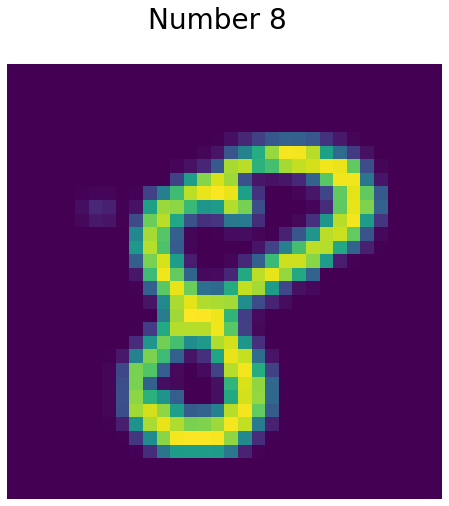

In [14]:
def preprocess_dataset(raw_images, num_classes=10, width=32, height=32):
    tfms = transforms.Compose([
        transforms.Resize((width, height)),
        transforms.PILToTensor()
    ])
    
    images = []
    labels = []
    count = 0
    
    for image, label in raw_images:
        tensor_image = tfms(image)
        tensor_image = tensor_image.permute(1, 2, 0).unsqueeze(0) # Shape - (batch, channels, width, height)
        
        images.append(tensor_image)
        
        one_hot_label = torch.zeros((1, num_classes))
        one_hot_label[:, label] = 1
        
        labels.append(one_hot_label)
        
    images = torch.cat(images)
    labels = torch.cat(labels)
    
#     print(f"Images shape: {images.shape}\nLabels shape: {labels.shape}\n")
    
    return images, labels
    
def plot_image(images, labels):
    # Shape - (batch, widht, height, channel)
    
    idx = random.randint(0, len(images))
    
    image2plot = images[idx]
    label = torch.argmax(labels[idx]).item()
    
    fig, axs = plt.subplots(1,1, figsize=(8, 8))
    axs.imshow(image2plot)
    fig.suptitle(f"Number {label}", fontsize=28)
    plt.axis('off')
    
    plt.show()
    
X_train, y_train = preprocess_dataset(mnist_trainset, width=32, height=32)
X_test, y_test = preprocess_dataset(mnist_testset, width=32, height=32)

plot_image(X_train, y_train)

# Create dataset and dataloader

In [15]:
class MNISTDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.images, self.labels = preprocess_dataset(data, num_classes=NUM_CLASSES, width=WIDTH, height=HEIGHT)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [16]:
train_ds = MNISTDataset(mnist_trainset)
test_ds = MNISTDataset(mnist_testset)

In [17]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

# Create an instance of the model

In [18]:
torch.cuda.empty_cache()

vit = ViT(image_shape=(BATCH_SIZE, WIDTH, HEIGHT, CHANNELS),
          patch_size=PATCHES_DIM,
          emb_dim=EMBEDDING_DIM,
          num_categories=NUM_CLASSES,
          nheads=NHEADS, 
          num_layers=NUM_LAYERS,
          dropout_p=DROPOUT_P,
          att_bias=False,
          forward_expansion=FORWARD_EXPANSION,
          mlp_expansion=MLP_EXPANSION,
          device=DEVICE
         ).to(DEVICE)

optim = torch.optim.SGD(vit.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss()

# Training and evaluate the model

In [19]:
def train_model(model, data, criterion, optimizer, device):
    model.train()
    
    optimizer.zero_grad()
    
    images, categories = data
    
    images = images.float() # Shape - (batch, width, height, channels)
    categories = categories.float().to(device) # Shape - (batch, num_categories)
    
    preds = model(images)
    
    corrects = torch.sum((torch.argmax(preds, dim=1) == torch.argmax(categories, dim=1)).int())
    number_samples = categories.shape[0]
    
    acc = corrects / number_samples

#     print(f"Accuracy: {corrects / number_samples} Number of samples: {number_samples} Corrects: {corrects}")
    
    loss = criterion(preds, categories)
    
    loss.backward()
    optimizer.step()
    
    return loss.item(), acc

In [20]:
def eval_model(model, data, criterion, device):
    model.eval()
    with torch.no_grad():
        images, categories = data
        
        images = images.float()
        categories = categories.float().to(device)
        
        preds = model(images)
        
        corrects = torch.sum((torch.argmax(preds, dim=1) == torch.argmax(categories, dim=1)).int())
        number_samples = categories.shape[0]
    
        acc = corrects / number_samples
        
        loss = criterion(preds, categories)
        
        return loss.item(), acc

In [21]:
training_loss_epoch = []
training_acc_epoch = []

eval_loss_epoch = []
eval_acc_epoch = []

torch.cuda.empty_cache()

for ep in range(1, EPOCHS + 1):
    # Train
    train_loss_epoch = 0
    train_acc_epoch = 0
    
    for data in train_dl:
        if data[0].shape[0] == BATCH_SIZE: # Check if there are same number of images as batch size
            loss, acc = train_model(vit, data, criterion, optim, DEVICE)
        
            train_loss_epoch += loss
            train_acc_epoch += acc
    
    training_loss_epoch.append(train_loss_epoch / BATCH_SIZE)
    training_acc_epoch.append(train_acc_epoch / BATCH_SIZE)
    
    print(f"|TRAINING|Epoch number: {ep}|Loss: {training_loss_epoch[-1]}|Accuracy: {training_acc_epoch[-1]}|")
    
    torch.cuda.empty_cache()

    # Test
    test_loss_epoch = 0
    test_acc_epoch = 0
    
    for data in test_dl:
        if data[0].shape[0] == BATCH_SIZE: # Check if there are same number of images as batch size
            loss, acc = eval_model(vit, data, criterion, DEVICE)

            test_loss_epoch += loss
            test_acc_epoch += acc
        
    eval_loss_epoch.append(test_loss_epoch / BATCH_SIZE)
    eval_acc_epoch.append(test_acc_epoch / BATCH_SIZE)
        
    print(f"|TEST    |Epoch number: {ep}|Loss: {eval_loss_epoch[-1]}|Accuracy: {eval_acc_epoch[-1]}|\n")

|TRAINING|Epoch number: 1|Loss: 57.7973148804158|Accuracy: 39.4951171875|
|TEST    |Epoch number: 1|Loss: 5.5975954993627965|Accuracy: 7.9697265625|

|TRAINING|Epoch number: 2|Loss: 38.91039568069391|Accuracy: 45.5986328125|
|TEST    |Epoch number: 2|Loss: 4.588100387016311|Accuracy: 8.2724609375|

|TRAINING|Epoch number: 3|Loss: 33.9445133570116|Accuracy: 47.2421875|
|TEST    |Epoch number: 3|Loss: 3.934778643772006|Accuracy: 8.5185546875|

|TRAINING|Epoch number: 4|Loss: 30.591266679693945|Accuracy: 48.2900390625|
|TEST    |Epoch number: 4|Loss: 3.710904291132465|Accuracy: 8.638671875|

|TRAINING|Epoch number: 5|Loss: 28.414405033923686|Accuracy: 48.982421875|
|TEST    |Epoch number: 5|Loss: 3.4062108964426443|Accuracy: 8.654296875|

|TRAINING|Epoch number: 6|Loss: 26.547979576746002|Accuracy: 49.57421875|
|TEST    |Epoch number: 6|Loss: 3.324443028483074|Accuracy: 8.6904296875|

|TRAINING|Epoch number: 7|Loss: 25.092968486482278|Accuracy: 49.974609375|
|TEST    |Epoch number: 7|Loss

# Plot the model performance

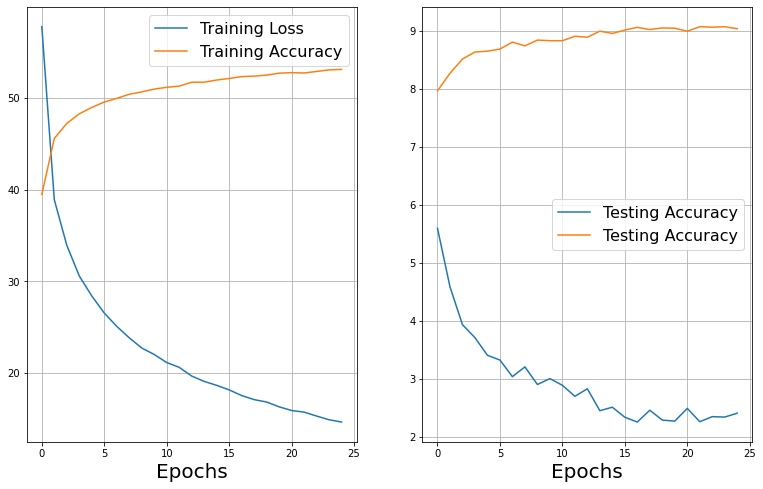

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(13, 8))

axs[0].plot(training_loss_epoch, label="Training Loss")
axs[0].plot(training_acc_epoch, label="Training Accuracy")
axs[0].grid(True)
axs[0].legend(prop={'size': 16})
axs[0].set_xlabel("Epochs", fontsize=20)

axs[1].plot(eval_loss_epoch, label="Testing Accuracy")
axs[1].plot(eval_acc_epoch, label="Testing Accuracy")
axs[1].grid(True)
axs[1].legend(prop={'size': 16})
axs[1].set_xlabel("Epochs", fontsize=20)

plt.show()

# Testing the model

In [36]:
def test_model(model, data, device, div=4):
    model.eval()
    
    images, categories = data
    
    images = images.float()
    categories = categories.float().to(device)
    
    with torch.no_grad():
        
        preds = model(images)
        
        corrects = torch.sum((torch.argmax(preds, dim=1) == torch.argmax(categories, dim=1)).int())
        number_samples = categories.shape[0]
        acc = (corrects / number_samples) * 100
    
        print(f"|Total images: {number_samples}|Corrected predicted: {corrects}| Accuracy: {acc}%|")
        
        preds = torch.max(preds, dim=1).indices
        
        num_rows = number_samples // div
        
        fig, axs = plt.subplots(num_rows, div, figsize=(15, 15))
        rows, cols = axs.shape
        
        j = 0
        img_idx = 0
        
        for r in range(rows):
            for c in range(cols):
                axs[r][c].imshow(images[img_idx,:,:,:])
                axs[r][c].set_title(f"Prediction: {preds[j].item()}")
                axs[r][c].axis('off')

                j += 1
                img_idx +=1
                    
        fig.tight_layout()
        plt.show()

|Total images: 32|Corrected predicted: 28| Accuracy: 87.5%|


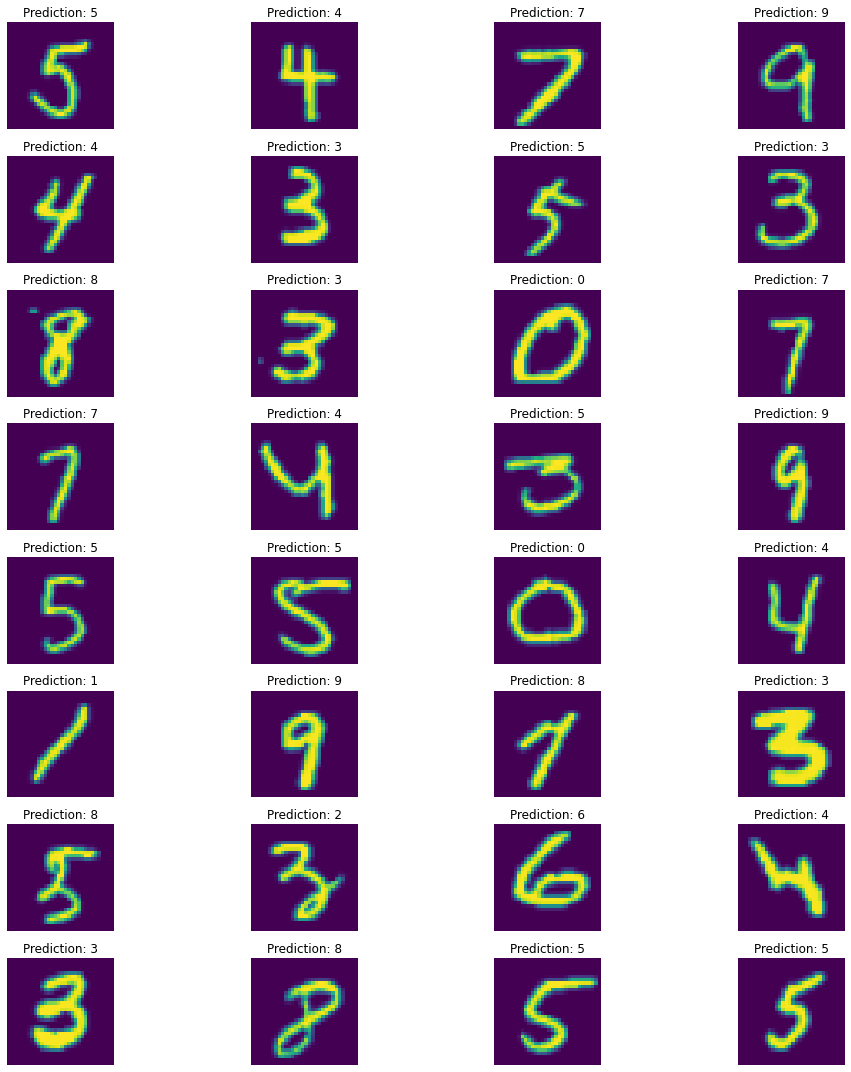

In [37]:
random_data = next(iter(test_dl))
test_model(vit, random_data, DEVICE)